In [1]:
%matplotlib inline

import os
import sys
import zipfile
import itertools
from argparse import Namespace
if sys.version_info.major == 2:
    from urllib import urlretrieve
    str = basestring
else:
    from urllib.request import urlretrieve

import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

URL = 'http://wals.info/static/download/wals-language.csv.zip'
ARCHIVE = URL.rpartition('/')[2]
EXTRACT = 'language.csv'

def crosstab(df, index, columns, tests=False, margins=True, dropna=True, **kwargs):
    idx = [df[i] for i in index] if isinstance(index, list) else df[index]
    cols = [df[c] for c in columns] if isinstance(columns, list) else df[columns] 
    result = pd.crosstab(idx, cols, margins=margins, dropna=dropna, **kwargs)
    if tests:
        result = Namespace(df=result)
        values = result.df.iloc[:-1, :-1] if margins else result.df
        testres = (chi2_contingency(values),)
        if tests != 'raw':
            label = tests if isinstance(tests, str) else '%s & %s' % (index, columns)
            testres = [tr.to_frame(label).T for tr in testres]
            result.expected = pd.DataFrame(testres[0].at[label, 'expected'],
                index=values.index, columns=values.columns)
        result.chi2, = testres
    return result

def chi2_contingency(x, func=scipy.stats.chi2_contingency):
    try:
        chi2, p, dof, expected = func(x)
    except ValueError:
        return
    result = chi2, p, dof, expected, (expected >= 5).all()
    return pd.Series(result, index=('chi2', 'p', 'dof', 'expected', 'usable'))

if not os.path.exists(ARCHIVE):
    urlretrieve(URL, ARCHIVE)

with zipfile.ZipFile(ARCHIVE) as archive:
    csv = pd.read_csv(archive.open(EXTRACT), encoding='utf-8', na_values='', keep_default_na=False)

csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Columns: 202 entries, wals_code to 79B Suppletion in Imperatives and Hortatives
dtypes: float64(2), object(200)
memory usage: 4.1+ MB


In [2]:
df = csv.set_index('wals_code')
assert df.index.is_unique
assert df.columns.is_unique
df.iloc[:9, :9]

,iso_code,glottocode,Name,latitude,longitude,genus,family,macroarea,countrycodes
wals_code,,,,,,,,,
aab,NaN,NaN,Arapesh (Abu),-3.450000,142.950000,Kombio-Arapesh,Torricelli,NaN,PG
aar,aiw,aari1239,Aari,6.000000,36.583333,South Omotic,Afro-Asiatic,Africa,ET
aba,aau,abau1245,Abau,-4.000000,141.250000,Upper Sepik,Sepik,Papunesia,PG
abb,shu,chad1249,Arabic (Abbéché Chad),13.833333,20.833333,Semitic,Afro-Asiatic,Africa,TD
abd,abi,abid1235,Abidji,5.666667,-4.583333,Kwa,Niger-Congo,Africa,CI
abe,apc,nort3139,Arabic (Beirut),33.916667,35.500000,Semitic,Afro-Asiatic,Eurasia,LB
abh,abv,baha1259,Arabic (Bahrain),26.000000,50.500000,Semitic,Afro-Asiatic,Eurasia,BH
abi,axb,abip1241,Abipón,-29.000000,-61.000000,South Guaicuruan,Guaicuruan,South America,AR
abk,abk,abkh1244,Abkhaz,43.083333,41.000000,Northwest Caucasian,Northwest Caucasian,Eurasia,GE


In [3]:
df.columns[:9]

Index(['iso_code', 'glottocode', 'Name', 'latitude', 'longitude', 'genus',
       'family', 'macroarea', 'countrycodes'],
      dtype='object')

In [4]:
df.columns[9:]

Index(['1A Consonant Inventories', '2A Vowel Quality Inventories',
       '3A Consonant-Vowel Ratio', '4A Voicing in Plosives and Fricatives',
       '5A Voicing and Gaps in Plosive Systems', '6A Uvular Consonants',
       '7A Glottalized Consonants', '8A Lateral Consonants',
       '9A The Velar Nasal', '10A Vowel Nasalization',
       ...
       '137B M in Second Person Singular', '136B M in First Person Singular',
       '109B Other Roles of Applied Objects',
       '10B Nasal Vowels in West Africa',
       '25B Zero Marking of A and P Arguments',
       '21B Exponence of Tense-Aspect-Mood Inflection',
       '108B Productivity of the Antipassive Construction',
       '130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'',
       '58B Number of Possessive Nouns',
       '79B Suppletion in Imperatives and Hortatives'],
      dtype='object', length=192)

In [5]:
lf = df.iloc[:, :9]
ff = df.iloc[:, 9:]

# Languages

In [6]:
lf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2679 entries, aab to zzo
Data columns (total 9 columns):
iso_code        2622 non-null object
glottocode      2660 non-null object
Name            2679 non-null object
latitude        2679 non-null float64
longitude       2679 non-null float64
genus           2679 non-null object
family          2679 non-null object
macroarea       2656 non-null object
countrycodes    2677 non-null object
dtypes: float64(2), object(7)
memory usage: 289.3+ KB


In [7]:
lf[lf.isnull().any(axis=1)].style.highlight_null().set_uuid('8')

,iso_code,glottocode,Name,latitude,longitude,genus,family,macroarea,countrycodes
wals_code,,,,,,,,,
aab,nan,nan,Arapesh (Abu),-3.45,142.95,Kombio-Arapesh,Torricelli,nan,PG
alc,nan,alle1238,Allentiac,-31,-68,Huarpe,Huarpe,South America,AR
ayo,nan,nan,Ayomán,11,-69,Jirajaran,Jirajaran,nan,VR
bah,xir,xiri1243,Xiriana,2.66667,-62.5,Bahuanic,Arawakan,nan,BR
bfg,nan,nan,Berber (Figuig),32.5,-1.5,Berber,Afro-Asiatic,nan,MA
bgn,nan,bugu1246,Bugun,27.5,92.5833,Western Arunachal,Sino-Tibetan,Eurasia,IN
bnu,nan,bula1255,Bularnu,-21,138,Western Pama-Nyungan,Pama-Nyungan,Australia,AU
bti,nan,beto1236,Betoi,7.16667,-71.25,Betoi,Betoi,South America,VR CO
cco,nan,tutu1242,Chasta Costa,42.6667,-124,Athapaskan,Na-Dene,North America,US


In [8]:
nf = lf[['Name', 'family', 'macroarea']]
nf.head()

,Name,family,macroarea
wals_code,,,
aab,Arapesh (Abu),Torricelli,NaN
aar,Aari,Afro-Asiatic,Africa
aba,Abau,Sepik,Papunesia
abb,Arabic (Abbéché Chad),Afro-Asiatic,Africa
abd,Abidji,Niger-Congo,Africa


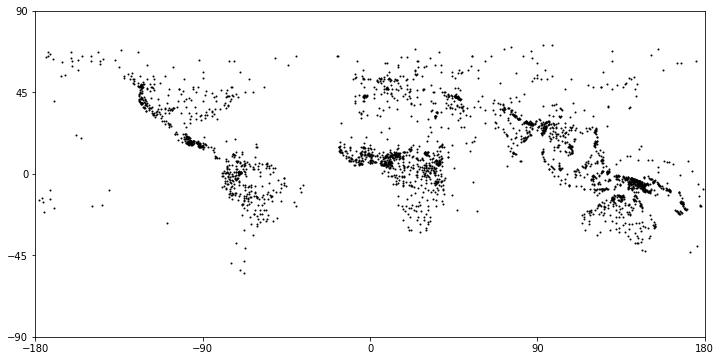

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis([-180, 180, -90, 90])
ax.set_xticks(range(-180, 181, 90))
ax.set_yticks(range(-90, 91, 45))
ax.scatter('longitude', 'latitude', 1, color='k', data=lf);

# Features

In [10]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2679 entries, aab to zzo
Columns: 192 entries, 1A Consonant Inventories to 79B Suppletion in Imperatives and Hortatives
dtypes: object(192)
memory usage: 4.0+ MB


In [11]:
ff.count().sum()

76465

In [12]:
ff.count().sort_values(ascending=False).to_frame('n')[:20]

,n
83A Order of Object and Verb,1519
82A Order of Subject and Verb,1497
"81A Order of Subject, Object and Verb",1377
87A Order of Adjective and Noun,1366
143G Minor morphological means of signaling negation,1324
143E Preverbal Negative Morphemes,1324
143A Order of Negative Morpheme and Verb,1324
143F Postverbal Negative Morphemes,1324
97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,1316
86A Order of Genitive and Noun,1249


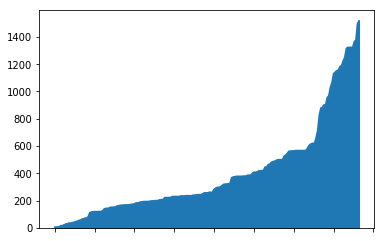

In [13]:
ff.count().sort_values().plot.area();

In [14]:
ff.count(axis=1).sort_values(ascending=False).to_frame('n')[:20].join(nf)

,n,Name,family,macroarea
wals_code,,,,
eng,159,English,Indo-European,Eurasia
fre,158,French,Indo-European,Eurasia
ger,157,German,Indo-European,Eurasia
rus,156,Russian,Indo-European,Eurasia
hun,155,Hungarian,Uralic,Eurasia
grk,155,Greek (Modern),Indo-European,Eurasia
spa,155,Spanish,Indo-European,Eurasia
fin,155,Finnish,Uralic,Eurasia
tur,154,Turkish,Altaic,Eurasia


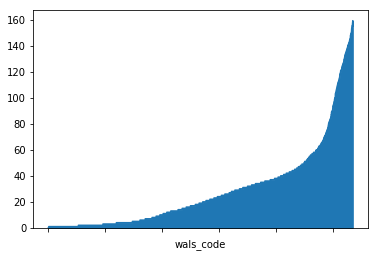

In [15]:
ff.count(axis=1).sort_values().plot.area();

In [16]:
pf = ff.reset_index().melt(id_vars='wals_code', var_name='Feature', value_name='Value')
pf = pf.set_index('wals_code').dropna()
pf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76465 entries, abi to zun
Data columns (total 2 columns):
Feature    76465 non-null object
Value      76465 non-null object
dtypes: object(2)
memory usage: 1.8+ MB


In [17]:
ct = crosstab(ff, '82A Order of Subject and Verb', '83A Order of Object and Verb', tests=True)
ct.df

83A Order of Object and Verb,1 OV,2 VO,3 No dominant order,All
82A Order of Subject and Verb,,,,
1 SV,677,457,51,1185
2 VS,7,180,4,191
3 No dominant order,12,55,42,109
All,696,692,97,1485


In [18]:
ct.chi2.drop('expected', axis=1)

,chi2,p,dof,usable
82A Order of Subject and Verb & 83A Order of Object and Verb,428.033,2.43353e-91,4,True


In [19]:
def ff_combos(ff, _crosstab=pd.crosstab, _chi2=scipy.stats.chi2_contingency):
    for f1, f2 in itertools.combinations(ff.columns, 2):
        try:
            ct = _crosstab(ff[f1], ff[f2])
        except KeyError:
            yield f1, f2, None, None, 0, None, False
            continue
        try:
            chi2, p, dof, expected = _chi2(ct)
        except ValueError:
            yield f1, f2, None, None, 0, None, False
            continue
        usable = (expected >= 5).all()
        yield f1, f2, chi2, p, dof, expected, usable

cf = pd.DataFrame.from_records(ff_combos(ff.loc[:, ff.count() > 500]), index=['f1', 'f2'],
    columns=['f1', 'f2', 'chi2', 'p', 'dof', 'expected', 'usable'])
cf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1176 entries, (1A Consonant Inventories, 2A Vowel Quality Inventories) to (144L The Position of Negative Morphemes in SOV Languages, 143G Minor morphological means of signaling negation)
Data columns (total 5 columns):
chi2        1176 non-null float64
p           1176 non-null float64
dof         1176 non-null int64
expected    1176 non-null object
usable      1176 non-null bool
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 41.1+ KB


In [20]:
cf[cf['usable'] & (cf['p'] <= .05)].drop('expected', axis=1).sort_values('p')

chi2  \
f1                                                 f2                                                                
83A Order of Object and Verb                       97A Relationship between the Order of Object an...  1847.271817   
                                                   86A Order of Genitive and Noun                       583.596318   
86A Order of Genitive and Noun                     97A Relationship between the Order of Object an...   507.138961   
82A Order of Subject and Verb                      83A Order of Object and Verb                         428.033232   
1A Consonant Inventories                           3A Consonant-Vowel Ratio                             437.961402   
82A Order of Subject and Verb                      97A Relationship between the Order of Object an...   291.087109   
26A Prefixing vs. Suffixing in Inflectional Mor... 97A Relationship between the Order of Object an...   257.476262   
2A Vowel Quality Inventories                       3A Consonant-Vowel Ratio                             204.358155   
82A Order of Subject and Verb                      86A Order of Genitive and Noun                       185.933667   
2A Vowel Quality Inventories                       13A Tone                                              62.019211   
26A Prefixing vs. Suffixing in Inflectional Mor... 82A Order of Subject and Verb                         65.487326   
2A Vowel Quality Inventories                       4A Voicing in Plosives and Fricatives                 54.905155   
97A Relationship between the Order of Object an... 129A Hand and Arm                                     35.300489   
2A Vowel Quality Inventories                       97A Relationship between the Order of Object an...    36.249651   
4A Voicing in Plosives and Fricatives              13A Tone                                              31.663456   
2A Vowel Quality Inventories                       82A Order of Subject and Verb                         25.217630   
13A Tone                                           97A Relationship between the Order of Object an...    32.306291   
2A Vowel Quality Inventories                       130A Finger and Hand                                  15.485255   
97A Relationship between the Order of Object an... 130A Finger and Hand                                  18.809330   
3A Consonant-Vowel Ratio                           13A Tone                                              25.065159   
1A Consonant Inventories                           2A Vowel Quality Inventories                          24.731949   
129A Hand and Arm                                  130A Finger and Hand                                   9.301093   
83A Order of Object and Verb                       129A Hand and Arm                                     11.361300   
82A Order of Subject and Verb                      129A Hand and Arm                                     10.203992   
2A Vowel Quality Inventories                       83A Order of Object and Verb                          13.769892   
                                                   129A Hand and Arm                                      9.436961   
86A Order of Genitive and Noun                     129A Hand and Arm                                      6.724093   
1A Consonant Inventories                           13A Tone                                              16.422930   
26A Prefixing vs. Suffixing in Inflectional Mor... 129A Hand and Arm                                     11.140690   

                                                                                                                   p  \
f1                                                 f2                                                                  
83A Order of Object and Verb                       97A Relationship between the Order of Object an...   0.000000e+00   
                                                   86A Order of Genitive and Noun          

In [21]:
crosstab(ff, '83A Order of Object and Verb', '86A Order of Genitive and Noun')

86A Order of Genitive and Noun,1 Genitive-Noun,2 Noun-Genitive,3 No dominant order,All
83A Order of Object and Verb,,,,
1 OV,494,32,23,549
2 VO,122,398,53,573
3 No dominant order,39,16,17,72
All,655,446,93,1194


In [22]:
crosstab(ff, '82A Order of Subject and Verb', '86A Order of Genitive and Noun')

86A Order of Genitive and Noun,1 Genitive-Noun,2 Noun-Genitive,3 No dominant order,All
82A Order of Subject and Verb,,,,
1 SV,597,273,65,935
2 VS,18,136,14,168
3 No dominant order,35,35,13,83
All,650,444,92,1186


In [23]:
crosstab(ff, '1A Consonant Inventories', '3A Consonant-Vowel Ratio')

3A Consonant-Vowel Ratio,1 Low,2 Moderately low,3 Average,4 Moderately high,5 High,All
1A Consonant Inventories,,,,,,
1 Small,41,29,16,3,0,89
2 Moderately small,7,35,69,11,0,122
3 Average,10,35,106,39,10,200
4 Moderately large,0,1,37,36,19,93
5 Large,0,0,6,12,38,56
All,58,100,234,101,67,560


In [24]:
crosstab(ff, '26A Prefixing vs. Suffixing in Inflectional Morphology',
    '97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun')

97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,1 OV and AdjN,2 OV and NAdj,3 VO and AdjN,4 VO and NAdj,5 Other,All
26A Prefixing vs. Suffixing in Inflectional Morphology,,,,,,
1 Little affixation,0,30,14,77,15,136
2 Strongly suffixing,129,101,39,41,53,363
3 Weakly suffixing,23,37,8,31,11,110
4 Equal prefixing and suffixing,9,26,12,51,27,125
5 Weakly prefixing,2,15,10,43,15,85
6 Strong prefixing,0,4,7,42,3,56
All,163,213,90,285,124,875


In [25]:
crosstab(ff, '2A Vowel Quality Inventories', '82A Order of Subject and Verb')

82A Order of Subject and Verb,1 SV,2 VS,3 No dominant order,All
2A Vowel Quality Inventories,,,,
1 Small (2-4),41,16,13,70
2 Average (5-6),170,31,15,216
3 Large (7-14),113,12,4,129
All,324,59,32,415


In [26]:
crosstab(ff, '2A Vowel Quality Inventories', '130A Finger and Hand')

130A Finger and Hand,1 Identical,2 Different,All
2A Vowel Quality Inventories,,,
1 Small (2-4),16,36,52
2 Average (5-6),11,96,107
3 Large (7-14),2,38,40
All,29,170,199


In [27]:
crosstab(ff, '1A Consonant Inventories', '13A Tone')

13A Tone,1 No tones,2 Simple tone system,3 Complex tone system,All
1A Consonant Inventories,,,,
1 Small,47,23,7,77
2 Moderately small,77,22,11,110
3 Average,100,48,43,191
4 Moderately large,47,24,18,89
5 Large,32,15,9,56
All,303,132,88,523


In [28]:
crosstab(ff, '26A Prefixing vs. Suffixing in Inflectional Morphology', '129A Hand and Arm')

129A Hand and Arm,1 Identical,2 Different,All
26A Prefixing vs. Suffixing in Inflectional Morphology,,,
1 Little affixation,21,18,39
2 Strongly suffixing,41,98,139
3 Weakly suffixing,13,14,27
4 Equal prefixing and suffixing,19,32,51
5 Weakly prefixing,7,11,18
6 Strong prefixing,8,7,15
All,109,180,289
